This plots ROI values extracted from images that have been normalized using DARTEL, 
but the values have been extracted from ROI derived from a prior analysis done using images normalized using ANTs.

This is a bit awkward since the two normalizations may have shifted the structures to different locations but this was done before drawing ROIs from SPM analysis performed using DARTEL-normalized images.

In [32]:
%run /home/grg/git/alfa/nilearn-helper.py
%matplotlib inline

In [33]:
spmdir = '/home/grg/spm/'
subjects = json.load(open(osp.join(spmdir, 'data', 'subjects.json')))
subjects = [osp.split(e)[-1].split('_')[0] for e in glob('/tmp/roi_dartel_csf0/*.csv')]

In [34]:
def getdict(data, key, column, column2=None, value=None):
    import string
    if not value is None:
        data = data[data[column2] == value]
        
    d1 = dict([(string.atoi(str(int(e))), v) for e, v in data[[key, column]].to_dict(orient='split')['data']])
    return d1

fsvol_fp = osp.join(spmdir, 'data', 'aseg FS ALFA.xlsx')
vvol = pd.read_excel(fsvol_fp)    
d = getdict(vvol, 'subject', 'Volume_mm3', 'StructName', 'Right-Lateral-Ventricle')

In [35]:
# From AAL V4, load labels - names translation table
labels_fp = '/home/grg/data/templates/MNI_atlas_templates/aal_MNI_V4.txt'
df = pd.read_csv(labels_fp, sep='\t', skiprows=0)
labels = {}
for i in range(1,117):
    labels[i] = json.loads(df.to_json()).items()[0][1][str(i)]

roiname = 'Hippocampus_L'
roilabel = [k for k,v in labels.items() if v == roiname][0]
print roiname, roilabel

def collect_data(verbose=False):
    
    # Loading json data etc..
    spmdir = '/home/grg/spm/'

    # Reading main tables with metadata
    demo_fp = osp.join(spmdir, 'data', 'Data_VBM_Alfa.csv')
    subj_fp= osp.join(spmdir, 'data', 'subjects.json')
    gend_fp= osp.join(spmdir, 'data', 'genders.json')
    grp_fp= osp.join(spmdir, 'data', 'apoe_groups.json')
    educ_fp = osp.join(spmdir, 'data', 'educyears.json')
    tiv_fp = osp.join(spmdir, 'data', 'tiv.json')
    fsvol_fp = osp.join(spmdir, 'data', 'aseg FS ALFA.xlsx')
    ages_fp = osp.join(spmdir, 'data', 'age.json') # contains ages in days

    demo = pd.read_csv(demo_fp)
    subjects = json.load(open(subj_fp))
    subjects = [string.atoi(osp.split(e)[-1].split('_')[0]) for e in glob('/tmp/roi_dartel_csf0/*.csv')]
    print len(subjects)

    # Sorting out groups
    groups = json.load(open(grp_fp))
    ages = json.load(open(ages_fp))
    genders = json.load(open(gend_fp))
    educyears = json.load(open(educ_fp))
    tivs = json.load(open(tiv_fp))
    vvol = pd.read_excel(fsvol_fp)    
    
    # FreeSurfer Volumes
    vvol_l = getdict(vvol, 'subject', 'Volume_mm3', 'StructName', 'Left-Lateral-Ventricle')
    vvol_r = getdict(vvol, 'subject', 'Volume_mm3', 'StructName', 'Right-Lateral-Ventricle')
    vvol_li = getdict(vvol, 'subject', 'Volume_mm3', 'StructName','Left-Inf-Lat-Vent')
    vvol_ri = getdict(vvol, 'subject', 'Volume_mm3', 'StructName','Right-Inf-Lat-Vent')
    vvol_3 = getdict(vvol, 'subject', 'Volume_mm3', 'StructName','3rd-Ventricle')
    vvol_4 = getdict(vvol, 'subject', 'Volume_mm3', 'StructName', '4th-Ventricle')    
    
    # Building dataframe
    data = []
    subj = []
    for s in subjects:    
        if verbose: print s
        group_nb = groups[str(s)]
        row = []
        try:
            fsvol_l = (vvol_l[s] + vvol_li[s]) / tivs[str(s)]
            fsvol_r = (vvol_r[s] + vvol_ri[s]) / tivs[str(s)]
            fsvol = fsvol_l + fsvol_r
            age = ages[str(s)]
            row.append(group_nb)
            row.extend([age/365.25, genders[str(s)], educyears[str(s)], fsvol])            
            subj.append(s)
            data.append(row)
        except KeyError as e:
            print e
        except IndexError as e:
            print e
            print 'removed', s
            
    columns=['apo', 'age', 'gender', 'educyears', 'ventricles']
    return pd.DataFrame(data, index=subj, columns=columns)

data = collect_data()
#data.to_excel('/tmp/covariates.xls')

Hippocampus_L 37
0


In [46]:
def collect_roivalues(roilabel, verbose=False):
    ''' This collect the values from *_AAL_MD_stats.csv files, that is 
    MD mean values in every subject's NATIVE space.
    '''
    
    subjects  = json.load(open('/home/grg/spm/data/subjects.json'))
    subjects = [string.atoi(osp.split(e)[-1].split('_')[0]) for e in glob('/home/grg/spm/ROIapoE/roi_dartel_csf.5/*.csv')]

    data_wd = '/home/grg/data/ALFA_DWI'
    
    data = []
    subj = []
    
    for s in subjects:    
        fp = '/home/grg/spm/ROIapoE/roi_dartel_csf.5/%s_stats.csv'%s
        if verbose:
            print s, fp
        df = pd.read_csv(fp, sep='\t').set_index('ROI_label')   
        try:
            data.append(df.ix[roilabel]['mean'])            
            subj.append(s)            
        except KeyError as e:
            print 'KeyError: skipped subject', s, 'label', e
        except IndexError as e:
            print 'IndexError: skipped subject', s, 'label', e
    return pd.DataFrame(data, index=subj, columns=['roi'])

In [47]:
def correct(df):
    model = 'roi ~ 1 + C(apo) + gender + educyears + ventricles'
    test_scores = ols(model, data=df).fit()
    
    err = test_scores.predict(df) - df['roi']
    ycorr = np.mean(df['roi']) - err   
    
    return ycorr

# Loading, joining, dropping etc.
data = pd.read_excel('/tmp/covariates.xls')
data = data.drop(data[data['ventricles']>30].index)
data['subject'] = data.index
data = data.sort_values(['apo', 'subject'])
#roilabel = 1
#roivalues = collect_roivalues(roilabel)
#df = data.join(roivalues)
#df['subject'] = df.index
#df = df.sort_values(['apo', 'subject']).dropna()
#df = df.drop(df[df['ventricles']>30].index)

# Correcting data for covariates
#ycorr = correct(df)
#df = data.join(ycorr)
#df['subject'] = df.index
#df = df.sort_values(['apo', 'subject']).dropna()
#df = df.drop(df[df['ventricles']>30].index)


data.head()

,apo,age,gender,educyears,ventricles,subject
10070,0,50.781656,0,10,4.520876,10070
10102,0,64.065708,1,18,16.507219,10102
10108,0,58.683094,0,15,10.421616,10108
10235,0,61.245722,0,8,7.564201,10235
10365,0,48.720055,0,12,7.770477,10365


In [48]:
y_name = 'roi'
x_name = ['apo', 'age', 'gender', 'educyears', 'ventricles']
#test_scores = sm.OLS(np.asarray(df[y_name]), np.asarray(df[x_name])).fit()
model = 'roi ~ 1 + C(apo) + age + gender + educyears + ventricles'
test_scores = ols(model, data=df).fit()

NameError: name 'roi' is not defined

In [49]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

def set_figaxes(df):
    plt.xlabel('age')
    plt.ylabel('roi')
    plt.ylim([0.0005, df['roi'].max()])
    plt.xlim([df['age'].min(), df['age'].max()])

def plot_region(roiname, dataset, order=1, ax=None):
    if ax == None:
        fig = plt.figure(figsize=(6, 6))
        set_figaxes(dataset)
        ax = fig.add_subplot(111)

    colors = ['b','r','g','m','y']
    formulas = ['roi ~ 1 + age', 
                'roi ~ 1 + age + I(age**2)', 
                'roi ~ 1 + age + I(age**2) + I(age**3)']
    print 'Region:', roiname, '- Fitting order:', order, '- Formula:', formulas[order-1]
    
    # take each group separately  
    groups_names = ['apoe23', 'apoe24', 'apoe33', 'apoe34', 'apoe44']
    groups1 = []
    for i in xrange(5):
        groups1.append(dataset[dataset['apo'] == i])
    groups = []
    groups_names = ['C', 'NC']
    groups.append(pd.concat([groups1[i] for i in [1,3,4]]))
    groups.append(pd.concat([groups1[i] for i in [0,2]]))
        
    for i, df in enumerate(groups):
        ax.scatter(df['age'], df['roi'], edgecolors=colors[i], facecolors='none', 
                   label='%s'%groups_names[i].capitalize(), s=10, alpha=0.7)
        x = pd.DataFrame({'age': np.linspace(df['age'].min(), df['age'].max(), 100)})
        
        poly = ols(formula=formulas[order-1], data=df).fit()
        ypred = poly.predict(x)
        #print np.std(ypred)
        ax.plot(x['age'], ypred, colors[i]+'-', 
                label='%s Poly n=%s $R^2$=%.2f $AIC$=%.2f' % (groups_names[i].capitalize(), order, poly.rsquared, poly.aic), 
                alpha=1.0)

    ax.legend(prop={'size':8})
    ax.text(0.15, 0.95, roiname, horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)
    plt.title(roiname)


In [50]:
def plot_regions(data, regions, nb_orders=3):
    nb_regions = len(regions)
    fig = plt.figure(figsize=(8*nb_orders, 8*nb_regions), dpi=300, facecolor='white')
    
    for i, roilabel in enumerate(regions):
        labels = ['coronaradiata', 'thalamus_R', 'orb_L', 'orb_R', 'hypothal_R', 'pons', 'thalamus_L', 'hypothal_L', 'unknown']
        roiname = '%s'%labels[roilabel-1]
        # 1-st order
        ax = fig.add_subplot(nb_regions, nb_orders, nb_orders*i + 1)
        roivalues = collect_roivalues(roilabel)
        df = data.join(roivalues)
        print np.std(df['roi'])
        ycorr = pd.DataFrame(correct(df), columns=['roi'])
        df = data.join(ycorr)
        df['subject'] = df.index
        df = df.sort_values(['apo', 'subject']).dropna()
    
        set_figaxes(df)
        print np.std(df['roi'])
        plot_region(roiname, df, order=1, ax=ax)

        # 2-nd order
        ax = fig.add_subplot(nb_regions, nb_orders, nb_orders*i + 2)
        roivalues = collect_roivalues(roilabel)
        df = data.join(roivalues)
        ycorr = pd.DataFrame(correct(df), columns=['roi'])
        df = data.join(ycorr)
        df['subject'] = df.index
        df = df.sort_values(['apo', 'subject']).dropna()
    
        set_figaxes(df)
        plot_region(roiname, df, order=2, ax=ax)

        # 3-rd order
        ax = fig.add_subplot(nb_regions, nb_orders, nb_orders*i + 3)
        roivalues = collect_roivalues(roilabel)
        df = data.join(roivalues)
        ycorr = pd.DataFrame(correct(df), columns=['roi'])
        df = data.join(ycorr)
        df['subject'] = df.index
        df = df.sort_values(['apo', 'subject']).dropna()
    
        set_figaxes(df)
        plot_region(roiname, df, order=3, ax=ax)
 

This collect the values from \*\_stats.csv files, i.e. values that have been extracted from ROI manually drawn in MNI space.
The bad thing with this is that the ROI is defined in a reference space. This is subject to individual registration errors.

7.40726102502e-05
7.28209451433e-05
Region: coronaradiata - Fitting order: 1 - Formula: roi ~ 1 + age
Region: coronaradiata - Fitting order: 2 - Formula: roi ~ 1 + age + I(age**2)
Region: coronaradiata - Fitting order: 3 - Formula: roi ~ 1 + age + I(age**2) + I(age**3)
9.77637937412e-05
9.67083335896e-05
Region: thalamus_R - Fitting order: 1 - Formula: roi ~ 1 + age
Region: thalamus_R - Fitting order: 2 - Formula: roi ~ 1 + age + I(age**2)
Region: thalamus_R - Fitting order: 3 - Formula: roi ~ 1 + age + I(age**2) + I(age**3)
0.00022877490427
0.000225939468982
Region: orb_L - Fitting order: 1 - Formula: roi ~ 1 + age
Region: orb_L - Fitting order: 2 - Formula: roi ~ 1 + age + I(age**2)
Region: orb_L - Fitting order: 3 - Formula: roi ~ 1 + age + I(age**2) + I(age**3)
0.000248391875323
0.000243539213345
Region: orb_R - Fitting order: 1 - Formula: roi ~ 1 + age
Region: orb_R - Fitting order: 2 - Formula: roi ~ 1 + age + I(age**2)
Region: orb_R - Fitting order: 3 - Formula: roi ~ 1 + age + 

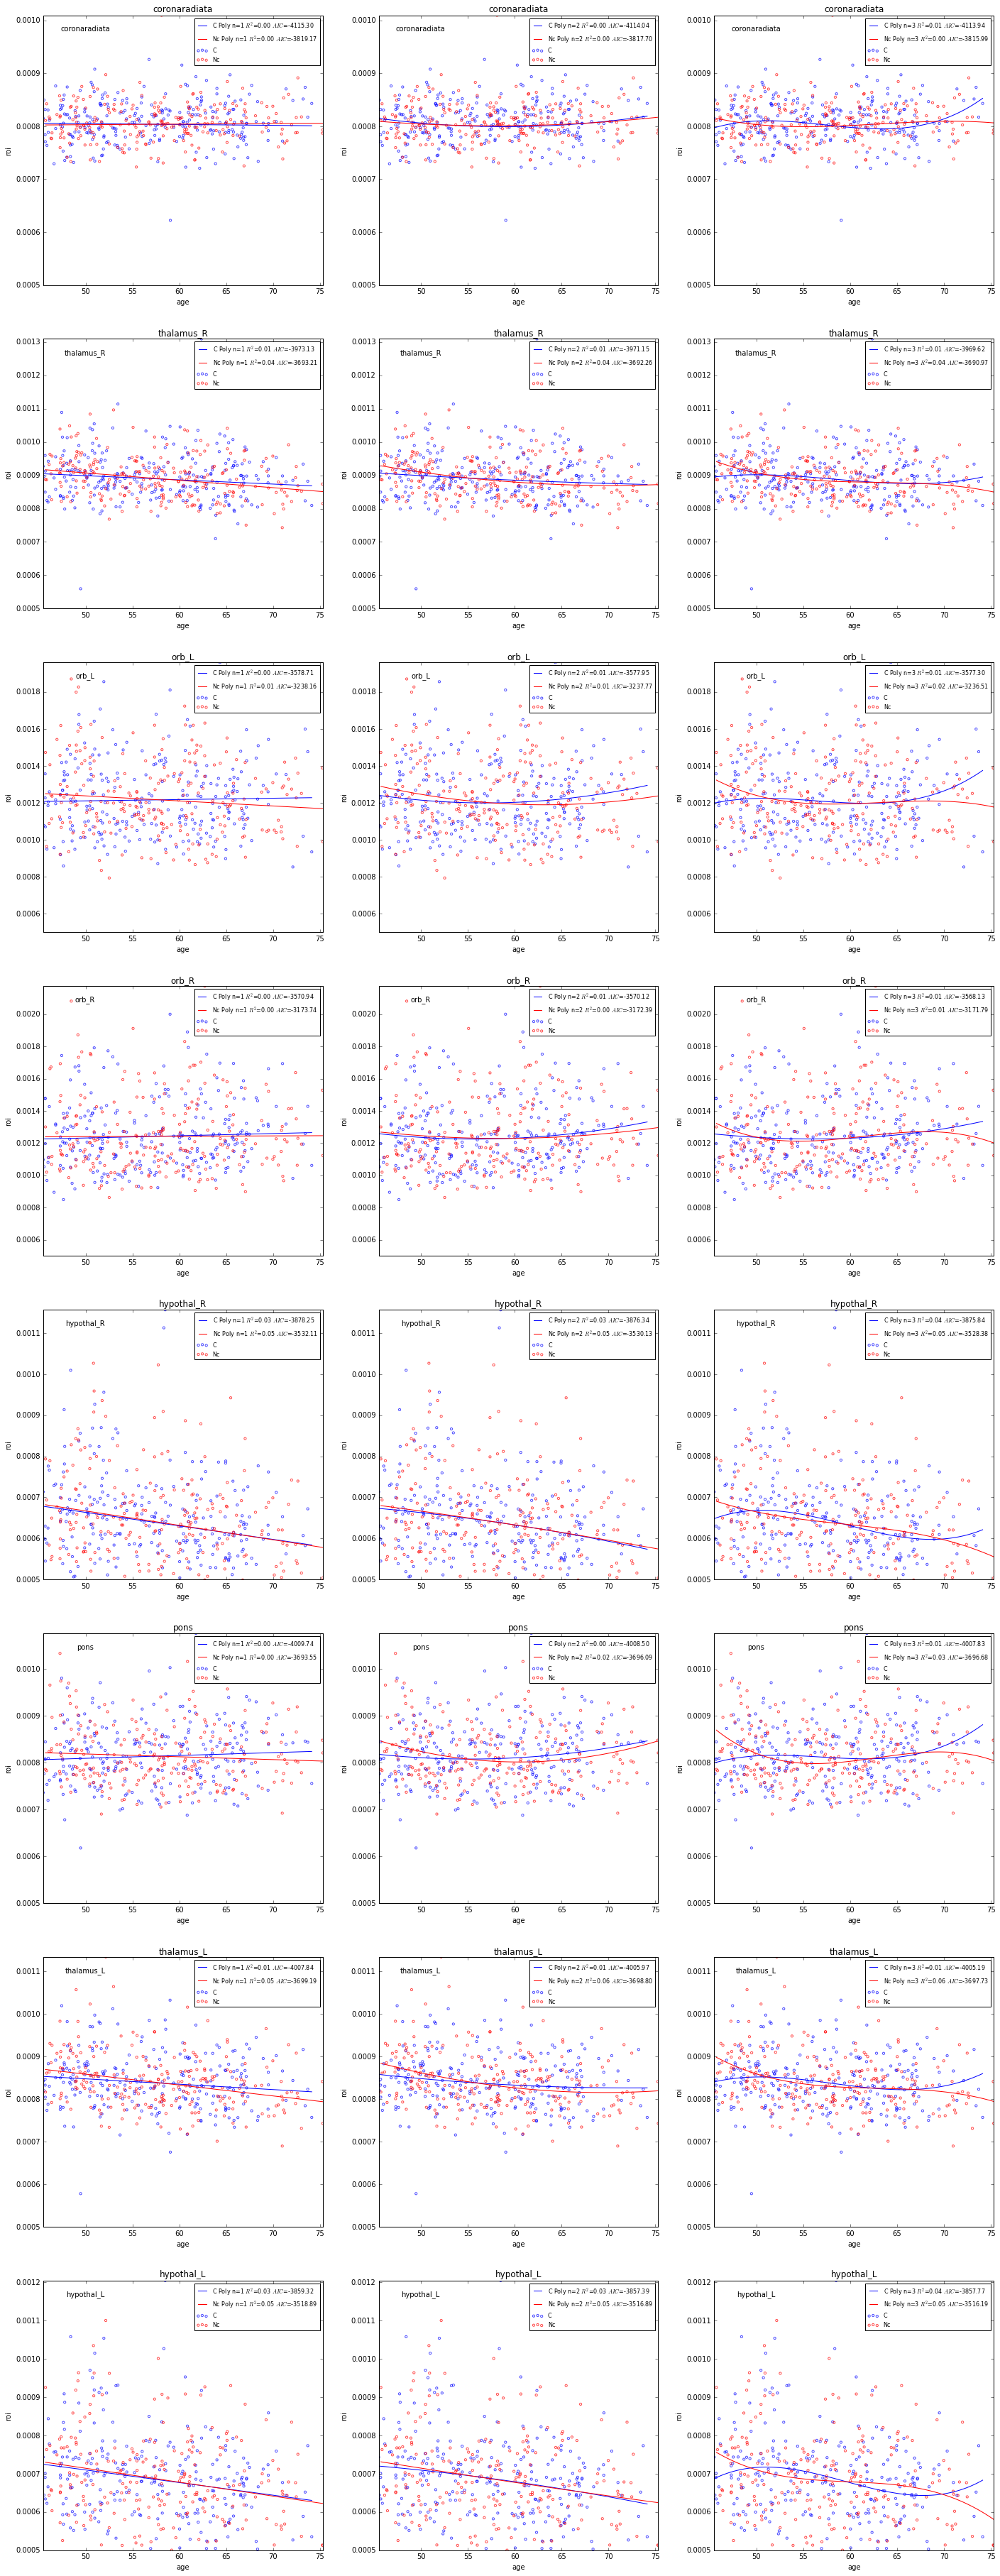

In [51]:
       
regions = [1,2,3,4,5,6,7,8]
plot_regions(data, regions)

#plot_regions(data, [71,72])

In [262]:
import plotly
#plotly.init_notebook_mode()

def plotly_region(roilabel):
    to_remove = [55166, 66159, 77068, 10182, 13059, 66019, 66264, 77024, 77263,
            10846, 66026, 66039, 66131, 66368, 77027, 77047]
    data = collect_data()
    roivalues = collect_roivalues(roilabel)
    #data = data[data['apo']==0]
    df = data.join(roivalues)
    df['subject'] = df.index
    df = df.drop(to_remove)
    
    
    import plotly.plotly as py
    import plotly.graph_objs as go

    #data = [trace]

    # Plot and embed in ipython notebook!
    #

    trace = go.Scatter3d(
        x = df['age'],
        y = df['roi'],
        z = df['ventricles'],
        marker=dict(
            size='4',
            color = df['apo'], #set color equal to a variable
            colorscale='Jet',
            showscale=True),
        text = df['subject'],
        mode = 'markers'
    )

    data = [trace]

    # Plot and embed in ipython notebook!
    py.iplot(data)
    # or plot with: plot_url = py.plot(data, filename='basic-line')

In [145]:
plotly_region(1)

514


In [115]:
data = collect_data()
roivalues = collect_roivalues(roilabel)
#data = data[data['apo']==0]
df = data.join(roivalues)
df['subject'] = df.index


import plotly.plotly as py
import plotly.graph_objs as go

#data = [trace]

# Plot and embed in ipython notebook!
#

trace = go.Scatter(
    x = df['age'],
    y = df['ventricles'],
    
    marker=dict(
        size='4',
        color = df['gender'], #set color equal to a variable
        colorscale='Jet',
        showscale=True),
    text = df['subject'],
    mode = 'markers'
)

data = [trace]

# Plot and embed in ipython notebook!
py.iplot(data)

514
KeyError: skipped subject 10070 label 37
KeyError: skipped subject 10102 label 37
KeyError: skipped subject 10108 label 37
KeyError: skipped subject 10235 label 37
KeyError: skipped subject 10365 label 37
KeyError: skipped subject 10419 label 37
KeyError: skipped subject 10463 label 37
KeyError: skipped subject 10530 label 37
KeyError: skipped subject 10551 label 37
KeyError: skipped subject 10563 label 37
KeyError: skipped subject 10576 label 37
KeyError: skipped subject 10630 label 37
KeyError: skipped subject 10668 label 37
KeyError: skipped subject 10692 label 37
KeyError: skipped subject 10693 label 37
KeyError: skipped subject 10703 label 37
KeyError: skipped subject 10725 label 37
KeyError: skipped subject 10737 label 37
KeyError: skipped subject 10756 label 37
KeyError: skipped subject 10809 label 37
KeyError: skipped subject 11045 label 37
KeyError: skipped subject 11047 label 37
KeyError: skipped subject 11048 label 37
KeyError: skipped subject 11133 label 37
KeyError: sk

In [148]:
sorted(to_remove)

[10182,
 10846,
 13059,
 55166,
 66019,
 66026,
 66039,
 66131,
 66159,
 66264,
 66368,
 77024,
 77027,
 77047,
 77068,
 77263]

In [174]:
df = collect_roivalues(1)
data = collect_data()
df2 = data.join(df).drop(data[data['ventricles']>30].index)



    

514


In [175]:
ypred = correct(df2)

In [176]:
type(ypred)

pandas.core.series.Series

In [269]:
order = 1
for i in range(1, 9):
    roivalues = collect_roivalues(i)
    df = data.join(roivalues)
    ycorr = pd.DataFrame(correct(df), columns=['roi'])
    df = data.join(ycorr)
    df['subject'] = df.index
    df = df.sort_values(['apo', 'subject']).dropna()
    formulas = ['roi ~ 1 + age'] #, 
    #        'roi ~ 1 + age + I(age**2)', 
    #        'roi ~ 1 + age + I(age**2) + I(age**3)']

    poly = ols(formula=formulas[0], data=df).fit()
    print poly.summary()
    
    break

                            OLS Regression Results                            
Dep. Variable:                    roi   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     5.929
Date:                Wed, 01 Feb 2017   Prob (F-statistic):             0.0152
Time:                        18:22:24   Log-Likelihood:                 4294.9
No. Observations:                 498   AIC:                            -8586.
Df Residuals:                     496   BIC:                            -8577.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0008   1.56e-05     49.838      0.0

In [234]:
poly.pvalues

Intercept      2.917992e-152
C(apo)[T.1]     9.495188e-01
C(apo)[T.2]     6.668016e-01
C(apo)[T.3]     7.440946e-01
C(apo)[T.4]     8.886761e-01
age             5.645333e-03
gender          9.564123e-01
educyears       6.172272e-01
ventricles      2.713613e-01
dtype: float64

Intercept    0.000721
age          0.000002
dtype: float64